### Parser

In [24]:
#libraries

import urllib.request, urllib.parse, urllib.error
import json
from bs4 import BeautifulSoup
import ssl
import re
import pandas as pd
import numpy as np
import sqlite3
import datetime
import time
import os
import matplotlib.pyplot as plt

In [25]:
#get list of studios

def studio_list():
    
    url = 'https://ugoloc.ru/studios/list.json'
    json_data = urllib.request.urlopen(url).read().decode()
    
    id = list()
    name = list()
    metro = list()
    address = list()
    phone = list()
    email = list()

    for i in range(len(json.loads(json_data)['features'])):
        id.append(json.loads(json_data)['features'][i]['studio']['id'])
        name.append(json.loads(json_data)['features'][i]['studio']['name'])
        metro.append(json.loads(json_data)['features'][i]['studio']['metro'])
        address.append(json.loads(json_data)['features'][i]['studio']['address'])
        phone.append(json.loads(json_data)['features'][i]['studio']['phone'])
        email.append(json.loads(json_data)['features'][i]['studio']['email'])

    return pd.DataFrame.from_dict({'studio_id': id, 
                                   'name': name, 
                                   'metro': metro, 
                                   'address': address, 
                                   'phone': phone, 
                                   'email': email}).set_index('studio_id')


In [26]:
#get list of entered studios_id halls 

def hall_list(studio_id):
    
    st_id = list()
    hall_id = list()
    name = list()
    is_hall = list()
    square = list()
    ceiling = list()
    
    for id in studio_id:
        url_studio = 'https://ugoloc.ru/studios/show/' + str(id)
        html = urllib.request.urlopen(url_studio).read()
        soup = BeautifulSoup(html, "html.parser")

        halls_html = soup.find_all('a', href=re.compile('studios/hall/'))
        halls = dict()
        for hall in halls_html:
            if int(hall.get('href').replace('/studios/hall/','')) not in hall_id:
                st_id.append(id)
                name.append(hall['title'])
                hall_id.append(int(hall.get('href').replace('/studios/hall/','')))
                if 'грим' in str.lower(hall['title']):
                    is_hall.append(0)
                else:
                    is_hall.append(1)
                    
                url_hall = 'https://ugoloc.ru/studios/hall/' + str(hall.get('href').replace('/studios/hall/',''))
                html_hall = urllib.request.urlopen(url_hall).read()
                soup_hall = BeautifulSoup(html_hall, "html.parser")
                
                try:
                    square.append(int(soup_hall.find_all('div', class_='param-value')[0].contents[0]))
                except:
                    square.append(np.nan)
                try:
                    ceiling.append(float(soup_hall.find_all('div', class_='param-value')[1].contents[0]))
                except:
                    ceiling.append(np.nan)
    
    return pd.DataFrame.from_dict({'studio_id': st_id, 
                                   'hall_id': hall_id, 
                                   'name': name, 
                                   'is_hall': is_hall,
                                   'square': square,
                                   'ceiling': ceiling
                                  }).set_index('hall_id')
    

In [27]:
#get current week booking in json (helping function)

def get_week_booking(id, week=0):
    url_booking = 'https://ugoloc.ru/studios/calendar/' + str(id) + '.json?week=' + str(week)

    json_booking = json.loads(urllib.request.urlopen(url_booking).read().decode())
    
    booking = {
        'hall_id': id,
        'week': week,
        'monday_date': json_booking['days']['1']['date'],
        'days': json_booking['days'],
        'hours': json_booking['hours'],
        'bookings': json_booking['bookings'],
        'prices': json_booking['prices'],
        'min_hours': json_booking['min_hours'],
        'is_opened': 1 if np.sum([len(json_booking['bookings'][str(x)]) for x in range(1, 8)]) > 0 else 0
    }
    time.sleep(.1)
    
    return booking
    
#get_week_booking(1413, -1)

In [28]:
#get hall's booking at past in json

def get_past_booking(id, weeks_ago = 500):
    week = -1
    null_period = 9
    flag = 0
    d = dict()
    
    while flag != 1:
        d[week] = get_week_booking(id, week)
        if (len(d) > null_period 
            and 1 not in [d[-1 * x]['is_opened'] for x in range(len(d) - 9, len(d))]
           ):
            
            flag = 1
            for x in range(0, null_period + 1):
                del d[week + x]
        
        if week < weeks_ago * -1:
            return d
        week += -1
    
    time.sleep(1)
    return d
        
#d = get_past_booking(1049)

In [29]:
#get hall's booking in future in json

def get_future_booking(id):
    week = 0
    null_period = 9
    flag = 0
    d = dict()
    
    while (flag != 1 and week <= 30):
        d[week] = get_week_booking(id, week)
        if (len(d) > null_period and 1 not in [d[x]['is_opened'] for x in range(len(d) - 9, len(d))]):
            flag = 1
            for x in range(0, null_period):
                del d[week - x]
            
        week += 1
    
    time.sleep(1)
    return d
        
#d = get_future_booking(1288)

In [30]:
#decode json to DataFrame

def hall_booking(d):
    hour = list(range(24))
    
    df = pd.DataFrame(columns=['hour', 'date', 'is_working_hour', 'price', 'duration', 'week', 'min_hours'])
    
    for week in d.keys():
        
        for weeks_day in range(1, 8):

            working_hour_is_text = 0
            cur_date = pd.Timestamp(datetime.datetime.strptime(d[week]['days'][str(weeks_day)]['date'], '%d.%m.%Y').isoformat())
            try:
                try:
                    working_hour = list([int(x) for x in d[week]['prices'][str(weeks_day)].keys()])
                    working_hour_is_text = 1
                except:
                    working_hour = list(d[week]['prices'][str(weeks_day)].keys())
            except:
                working_hour = list(range(len(d[week]['prices'][str(weeks_day)])))
            try:
                price = list(
                        d[week]['prices'][str(weeks_day)].values() 
                        if type(d[week]['prices'][str(weeks_day)].values()) != type(dict())
                        else d[week]['prices'][str(weeks_day)]
                        )
            except:
                price = list(
                        d[week]['prices'][str(weeks_day)]
                        if type(d[week]['prices'][str(weeks_day)]) != type(dict())
                        else d[week]['prices'][str(weeks_day)]
                        )

            try:
                booking_hours = sorted([int(x) for x in d[week]['bookings'][str(weeks_day)]])
                duration = [d[week]['bookings'][str(weeks_day)][str(h)]['duration'] for h in booking_hours]
            except:
                booking_hours = 0
                duration = 24
            min_hours = d[week]['min_hours']

            df_temp = pd.DataFrame(hour, columns = ['hour'])
            df_temp['date'] = cur_date
            df_temp['is_working_hour'] = [1 if y else 0 for y in [x in working_hour for x in hour]]
            df_temp['price'] = 0
            if len(working_hour) == 24:
                df_temp['price'] = price
            else:
                df_temp.loc[working_hour, 'price'] = price
            df_temp['duration'] = 0

            if duration != 24 and working_hour_is_text == 0:
                df_temp.loc[[x in booking_hours for x in df_temp['hour']], 'duration'] = duration
            elif duration != 24 and working_hour_is_text != 0:
                df_temp.loc[[x in booking_hours for x in df_temp['hour']], 'duration'] = duration
            else:
                df_temp.loc[0, 'duration'] = 24
            df_temp['week'] = week
            df_temp['min_hours'] = min_hours

            df = pd.concat([df, df_temp])
    
    df = df.sort_values(by=['week', 'date', 'hour'])
    df.index = list(range(len(df)))
    df['is_booked'] = 0
    
    for i in df.index:
        if df.loc[i, 'duration'] != 0:
            if i + df.loc[i, 'duration'] < df.index[-1]:
                df.loc[i:(i + int(df.loc[i, 'duration'])) - 1, 'is_booked'] = 1
            else:
                df.loc[i:, 'is_booked'] = 1
    
    df['hall_id'] = d[np.min(list(d.keys()))]['hall_id']
    
    return df

In [31]:
#create tables
def create_tables(conn, table = 'all'):
    cur = conn.cursor()
    
    if (table == 'all') or (table == 'uStudios'):
        cur.execute('''
            CREATE TABLE IF NOT EXISTS uStudios
            (studio_id INT PRIMARY KEY UNIQUE,
            name TEXT UNIQUE,
            metro TEXT,
            address TEXT,
            phone TEXT,
            email TEXT,
            established_date DATE)
            ''')
        print('Table uStudios is created.')

    if (table == 'all') or (table == 'uHalls'):
        cur.execute('''
            CREATE TABLE IF NOT EXISTS uHalls
            (hall_id INT PRIMARY KEY UNIQUE,
            studio_id INT,
            name TEXT,
            is_hall INT,
            square FLOAT,
            ceiling FLOAT,
            open_date DATE)
            ''')
        print('Table uHalls is created.')

    if (table == 'all') or (table == 'uBooking_parsing'):
        cur.execute('''
            CREATE TABLE IF NOT EXISTS uBooking_parsing
            (hall_id INT,
            date DATE,
            hour INT,
            is_working_hour INT,
            min_hours INT,
            price INTEGER,
            is_booked INT,
            duration INT,
            parsing_date DATE)
            ''')
        print ('Table uBooking_parsing is created.')

    if (table == 'all') or (table == 'uBooking'):
        cur.execute('''
            CREATE TABLE IF NOT EXISTS uBooking
            (hall_id INT,
            date DATE,
            hour INT,
            is_working_hour INT,
            min_hours INT,
            price INTEGER,
            is_booked INT,
            duration INT,
            parsing_date DATE)
            ''')
        print ('Table uBooking is created.')

In [32]:
def studios_to_db(conn, studio_list): 
    cur = conn.cursor()
    for i in studio_list.index:
        cur.execute('INSERT OR IGNORE INTO uStudios (studio_id, name, metro, address, phone, email) VALUES(?, ?, ?, ?, ?, ?)',
                   (i,
                   studio_list.loc[i, 'name'],
                   studio_list.loc[i, 'metro'],
                   studio_list.loc[i, 'address'],
                   studio_list.loc[i, 'phone'],
                   studio_list.loc[i, 'email']))

In [33]:
def db_to_studios(conn):
    cur = conn.cursor()
    cur.execute('SELECT * FROM uStudios')
    studios = pd.DataFrame(cur.fetchall()
                           , columns=['studio_id', 'name', 'metro', 'address', 'phone', 'email', 'established_date']
                          ).set_index('studio_id')
    studios['established_date'] = pd.to_datetime(studios['established_date'])
    return studios

In [34]:
def halls_to_db(conn, halls): 
    cur = conn.cursor()
    for i in halls.index:
        cur.execute('INSERT OR IGNORE INTO uHalls (hall_id, studio_id, name, is_hall, square, ceiling) VALUES(?, ?, ?, ?, ?, ?)',
                   (i,
                   halls.loc[i, 'studio_id'],
                   halls.loc[i, 'name'],
                   halls.loc[i, 'is_hall'],
                   halls.loc[i, 'square'],
                   halls.loc[i, 'ceiling']))

In [35]:
def db_to_halls(conn):
    cur = conn.cursor()
    cur.execute('SELECT * FROM uHalls')
    halls = pd.DataFrame(cur.fetchall(), columns=['hall_id', 'studio_id', 'name', 'is_hall', 'square', 'ceiling', 'open_date']).set_index('hall_id')
    for i in halls.index:
        halls.loc[i, 'studio_id'] = int.from_bytes(halls.loc[i, 'studio_id'], 'little')
        halls.loc[i, 'is_hall'] = int.from_bytes(halls.loc[i, 'is_hall'], 'little')
    halls['open_date'] = pd.to_datetime(halls['open_date'])
    return halls

In [36]:
def booking_to_db(conn, halls_id):
    cur = conn.cursor()
    cur_date = pd.Timestamp(datetime.date.today())
    parsing_date = db_to_booking(conn, parsing = 1).groupby('hall_id').agg(np.max)['parsing_date']
    
    for id in halls_id:
        
        #download last parsing_date from DataBase
        try:
            last_day_str = parsing_date[id]
            last_day = datetime.datetime.strptime(last_day_str, '%Y-%m-%d')
            delta_days = (datetime.datetime.now() - last_day).days
            weeks_ago = delta_days // 7
        except:
            last_day_str = '2010-01-01'
            last_day = datetime.datetime.strptime(last_day_str, '%Y-%m-%d')
            weeks_ago = 500
        
        d = get_past_booking(id, weeks_ago = weeks_ago)        
        d.update(get_future_booking(id))
        book = hall_booking(d)
        for i in list(range(len(book))):#book.index:
            cur.execute('INSERT OR IGNORE INTO uBooking_parsing (hall_id, date, hour, is_working_hour, min_hours, price, is_booked, duration, parsing_date) VALUES(?,?,?,?,?,?,?,?,?)',
                       (book.iloc[i]['hall_id'],
                       book.iloc[i]['date'].date().isoformat(),
                       book.iloc[i]['hour'],
                       book.iloc[i]['is_working_hour'],
                       book.iloc[i]['min_hours'],
                       book.iloc[i]['price'],
                       book.iloc[i]['is_booked'],
                       book.iloc[i]['duration'],
                       cur_date.date().isoformat()))
        conn.commit()
        print('hall_id ' + str(id) + ' added. ' + str(list(halls_id).index(id) + 1) + ' from ' + str(len(halls_id)))

In [37]:
def db_to_booking(conn, parsing = 0):
    cur = conn.cursor()
    if parsing == 1:
        cur.execute('SELECT * FROM uBooking_parsing')
    else:
        cur.execute('SELECT * FROM uBooking')
    booking = pd.DataFrame(cur.fetchall(), columns=['hall_id', 
                                                     'date', 'hour', 
                                                     'is_working_hour', 
                                                     'min_hours', 
                                                     'price', 
                                                     'is_booked', 
                                                     'duration', 
                                                     'parsing_date'])
    booking['hall_id'] = [int.from_bytes(x, 'little') if not isinstance(x, int) else x for x in booking['hall_id']]
    booking['is_booked'] = [int.from_bytes(x, 'little') if not isinstance(x, int) else x for x in booking['is_booked']]
    booking['date'] = pd.DataFrame(booking['date'])
    booking['parsing_date'] = pd.DataFrame(booking['parsing_date'])
    
    return booking

In [38]:
def update_open_dates(conn):
    
    cur = conn.cursor()
    
    #update open date in uHalls
    halls = db_to_booking(conn).groupby('hall_id').agg(min)['date']
    
    for i in list(range(len(halls))):
        cur.execute('''UPDATE uHalls SET open_date = '{1}' WHERE hall_id = {0}'''
                    .format(halls.index[i], str(halls.iloc[i])))

    #update open date in uStudios
    studios = db_to_halls(conn)
    studios['open_date'] = pd.to_datetime(studios['open_date'])
    studios = studios.groupby('studio_id').agg(min)['open_date']
    for i in list(range(len(studios))):
        cur.execute('''UPDATE uStudios SET established_date = '{1}' WHERE  studio_id = {0}'''
                    .format(studios.index[i], str(studios.iloc[i])))
    
    conn.commit()

In [39]:
def update_parsing(directory = './/', is_manual = 0):
    
    start_time = time.time()
    
    #is DataBase exists?
    if not os.path.exists(directory + 'photostudios_moscow1.sqlite'):
        if is_manual == 1:
            print('Data base is not exists. Do you want to create DataBase (y/n)? ')
            answer = input().lower()
        else: 
            answer == 'y'
        
        if answer == 'y':
            conn = sqlite3.connect(directory + 'photostudios_moscow1.sqlite')
            conn.close()
            print('DataBase is created')
        elif answer != 'n':
            print('Error in input!')
            return list()
    
    print('DataBase is exists')
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
        
    #connect to DataBase
    conn = sqlite3.connect(directory + 'photostudios_moscow1.sqlite')
    cur = conn.cursor()       

    #has DataBase 4 tables?
    tables = [x[0] for x in list(cur.execute('SELECT name FROM sqlite_master WHERE type="table"'))]
    if not ('uStudios' in tables) & ('uHalls' in tables) & ('uBooking_parsing' in tables) & ('uBooking' in tables):
        if is_manual == 1:
            print('Do you want to create missing tables (y/n)? ')
            answer = input().lower()
        else:
            answer = 'y'
        
        if anwer == 'y':
            if not ('uStudios' in tables):
                create_tables(conn, table = 'uStudios')

            if not ('uHalls' in tables):
                create_tables(conn, table = 'uHalls')

            if not ('uBooking_parsing' in tables):
                create_tables(conn, table = 'uBooking_parsing')

            if not ('uBooking' in tables):
                create_tables(conn, table = 'uBooking')

        elif answer != 'n':
            print('Error in input!')
            return list()

    conn.commit()
    print(str(tables) + ' are exist in DataBase')
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    
    #update uStudios
    studios = studio_list()
    new_studios = studios[[x not in list(db_to_studios(conn).index) for x in list(studios.index)]]
    if len(new_studios) > 0:
        print(str(len(new_studios)) + ' new studios detected: \n' + str(list(new_studios['name'])))
        studios_to_db(conn, new_studios)
    
    conn.commit()
    print('Studio list update was successful')
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    
    #update uHalls
    halls = hall_list(list(studios.index)).sort_index()
    new_halls = halls[[x not in list(db_to_halls(conn).index) for x in list(halls.index)]]
    if len(new_halls) > 0:
        halls_to_db(conn, new_halls)
    
    conn.commit()
    print('Halls list update was successful')
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
        
    #update uBooking_parsing
    booking_to_db(conn, halls.index)   
    
    conn.commit()
    print('Booking_parsing update was successful')
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    
    #update uBooking from uBooking_parsing
    cur.execute('DELETE FROM uBooking')
    cur.execute('''
        insert into uBooking (hall_id, date, hour, is_working_hour, min_hours, price, is_booked, duration, parsing_date) 
        select hall_id, date, hour, is_working_hour, min_hours, price, is_booked, duration, parsing_date
        from
        (
            select *, row_number() over(partition by hall_id, date, hour order by parsing_date desc) rn 
            from uBooking_parsing
        ) t
        where rn = 1
    ''')
    conn.commit()
    print('Booking update was successful')
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    
    update_open_dates(conn)
    conn.commit()
    print('Open date update was successful')
    print("--- %s seconds ---" % (time.time() - start_time))
    
    conn.close()


In [105]:
# update/create parsing data
update_parsing()

DataBase is exists
--- 0.0 seconds ---
['uStudios', 'uBooking', 'uHalls', 'uBooking_parsing'] are exist in DataBase
--- 0.006327629089355469 seconds ---
Studio list update was successful
--- 7.384583950042725 seconds ---
Halls list update was successful
--- 160.81548762321472 seconds ---
hall_id 23 added. 1 from 212
hall_id 24 added. 2 from 212
hall_id 55 added. 3 from 212
hall_id 56 added. 4 from 212
hall_id 57 added. 5 from 212
hall_id 58 added. 6 from 212
hall_id 59 added. 7 from 212
hall_id 60 added. 8 from 212
hall_id 189 added. 9 from 212
hall_id 191 added. 10 from 212
hall_id 192 added. 11 from 212
hall_id 326 added. 12 from 212
hall_id 362 added. 13 from 212
hall_id 363 added. 14 from 212
hall_id 364 added. 15 from 212
hall_id 375 added. 16 from 212
hall_id 428 added. 17 from 212
hall_id 430 added. 18 from 212
hall_id 464 added. 19 from 212
hall_id 465 added. 20 from 212
hall_id 472 added. 21 from 212
hall_id 496 added. 22 from 212
hall_id 497 added. 23 from 212
hall_id 523 add

### Analytics

In [43]:
# set connection

directory = './/'
conn = sqlite3.connect(directory + 'photostudios_moscow1.sqlite')
cur = conn.cursor()       

#### download tables from database

In [44]:
studios = db_to_studios(conn)
studios

,name,metro,address,phone,email,established_date
studio_id,,,,,,
7,Vox Studios,м. Дмитровская,"ул. Новодмитровская д. 5а, стр. 2",+7 915-423-48-10,info@voxstudios.ru,2018-02-19
16,StBrown,м.Алексеевская,"ул. Годовикова, дом 9, стр. 1, подъезд 1.7",+7 (906) 760 03 03,stbrown@bk.ru,2018-01-08
17,Look Studios,Кевская,"Бережковская набережная, 20 стр 19.",+7 (965) 222 39 49,lookstudioproject@gmail.com,2017-01-30
24,Citrusfoto,Серпуховская,"Партийный переулок, дом 1, корпус 11",+7 (915) 003-666-5,studio@citrusfoto.ru,2019-03-04
34,PRIDE STUDIO,м.Шаболовская,"Малая Калужская улица, 1с2",+7(495) 565 39 85,pridestudio24@gmail.com,2019-10-28
...,...,...,...,...,...,...
601,BLANK Studios,Электрозаводская,"Малая Семеновская, 5, ст1, 4 этаж",+7(495)970 28 37,info@blankstudios.ru,2020-03-09
606,Noks Studio,Электрозаводская,"г. Москва, ул. Электрозаводская, д. 21",8 (977) 916-18-94,noksstudio@gmail.com,2020-03-09
610,Mood Studio,Электрозаводская,"ул.Электрозаводская, 21",+7 977 924-18-70,info@moodstudio.ru,2020-06-29


In [45]:
halls = db_to_halls(conn)
halls

,studio_id,name,is_hall,square,ceiling,open_date
hall_id,,,,,,
23,7,studio 80,1,80.0,4.0,2018-02-19
24,7,studio 65,1,65.0,4.0,2018-02-19
55,16,LOFT,1,70.0,5.0,2018-01-15
56,16,GREEN,1,75.0,5.0,2018-01-15
57,16,INDI,1,65.0,5.0,2018-01-08
...,...,...,...,...,...,...
1530,585,Зал №5,1,100.0,5.7,2020-06-22
1533,624,Воздух,1,110.0,6.0,2020-06-29
1534,624,Марокко,1,107.0,6.0,2020-06-29


In [46]:
booking = db_to_booking(conn)
booking

,hall_id,date,hour,is_working_hour,min_hours,price,is_booked,duration,parsing_date
0,768,2018-06-11,0,0,2,0.0,0,0,2020-01-16
1,768,2018-06-11,1,0,2,0.0,0,0,2020-01-16
2,768,2018-06-11,2,0,2,0.0,0,0,2020-01-16
3,768,2018-06-11,3,0,2,0.0,0,0,2020-01-16
4,768,2018-06-11,4,0,2,0.0,0,0,2020-01-16
...,...,...,...,...,...,...,...,...,...
3306235,1023,2020-07-26,19,1,2,1600.0,0,0,2020-07-23
3306236,1023,2020-07-26,20,1,2,1600.0,0,0,2020-07-23
3306237,1023,2020-07-26,21,1,2,1600.0,0,0,2020-07-23
3306238,1023,2020-07-26,22,1,2,1600.0,0,0,2020-07-23


In [47]:
# delete studios without established date (bookings) 
# and dressing rooms from halls

studios = studios[[x.year > 0 for x in studios['established_date']]]
halls = halls[halls['is_hall'] == 1]

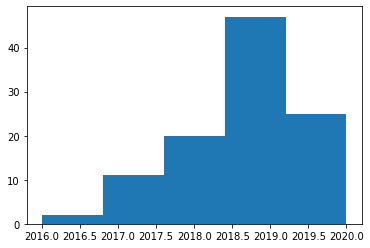

In [48]:
# established year distribition
num_bins = np.max(studios['established_date']).year - np.min(studios['established_date']).year + 1
plt.hist([x.year for x in studios['established_date']], num_bins)
plt.show()

In [49]:
# we can see that ugoloc.ru created in 2015-2016
# most customers added in 2019

In [50]:
# merge all tables
data = (booking
         .merge(halls, left_on = 'hall_id', right_on = 'hall_id', how = 'inner')
         .merge(studios, left_on ='studio_id', right_on = 'studio_id', how = 'inner')
        )
data = data[data['is_working_hour'] == 1]
data['date'] = pd.to_datetime(data['date'])
data

,hall_id,date,hour,is_working_hour,min_hours,price,is_booked,duration,parsing_date,studio_id,...,is_hall,square,ceiling,open_date,name_y,metro,address,phone,email,established_date
8,768,2018-06-11,8,1,2,1000.0,0,0,2020-01-16,316,...,1,65.0,5.0,2018-06-11,Wow Studios,Электрозаводская,"улица Электрозаводская, д. 21",8-965-338-43-58,info@wow-studios.ru,2018-06-11
9,768,2018-06-11,9,1,2,1000.0,0,0,2020-01-16,316,...,1,65.0,5.0,2018-06-11,Wow Studios,Электрозаводская,"улица Электрозаводская, д. 21",8-965-338-43-58,info@wow-studios.ru,2018-06-11
10,768,2018-06-11,10,1,2,700.0,0,0,2020-01-16,316,...,1,65.0,5.0,2018-06-11,Wow Studios,Электрозаводская,"улица Электрозаводская, д. 21",8-965-338-43-58,info@wow-studios.ru,2018-06-11
11,768,2018-06-11,11,1,2,700.0,0,0,2020-01-16,316,...,1,65.0,5.0,2018-06-11,Wow Studios,Электрозаводская,"улица Электрозаводская, д. 21",8-965-338-43-58,info@wow-studios.ru,2018-06-11
12,768,2018-06-11,12,1,2,700.0,0,0,2020-01-16,316,...,1,65.0,5.0,2018-06-11,Wow Studios,Электрозаводская,"улица Электрозаводская, д. 21",8-965-338-43-58,info@wow-studios.ru,2018-06-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921851,1534,2020-08-23,19,1,1,1700.0,0,0,2020-07-23,624,...,1,107.0,6.0,2020-06-29,The Gallery studio,Волгоградский проспект,Михайловский проезд 1 стр 3,+79153028566,thegallerymoscow@gmail.com,2020-06-29
2921852,1534,2020-08-23,20,1,1,1700.0,0,0,2020-07-23,624,...,1,107.0,6.0,2020-06-29,The Gallery studio,Волгоградский проспект,Михайловский проезд 1 стр 3,+79153028566,thegallerymoscow@gmail.com,2020-06-29
2921853,1534,2020-08-23,21,1,1,2000.0,0,0,2020-07-23,624,...,1,107.0,6.0,2020-06-29,The Gallery studio,Волгоградский проспект,Михайловский проезд 1 стр 3,+79153028566,thegallerymoscow@gmail.com,2020-06-29
2921854,1534,2020-08-23,22,1,1,2000.0,0,0,2020-07-23,624,...,1,107.0,6.0,2020-06-29,The Gallery studio,Волгоградский проспект,Михайловский проезд 1 стр 3,+79153028566,thegallerymoscow@gmail.com,2020-06-29


#### choose new created studios from all new

In [51]:
first_month = (data[data['date'] <= [x + datetime.timedelta(days = 15) for x in data['established_date']]]
               .loc[:, ['studio_id', 'price', 'duration']]
              )
first_month['income'] = first_month['price'] * first_month['duration']
first_month = first_month.groupby('studio_id').agg(np.sum)
first_month

,price,duration,income
studio_id,,,
7,1030400.0,163,231100.0
16,1180100.0,116,169300.0
17,264000.0,61,67100.0
24,1036800.0,322,176900.0
34,1203600.0,214,265500.0
...,...,...,...
601,935900.0,130,139700.0
606,325000.0,19,19000.0
610,286000.0,20,29000.0


In [52]:
month_after_year = (data[(data['date'] >= [x + datetime.timedelta(days = 365) for x in data['established_date']])
                         & (data['date'] <= [x + datetime.timedelta(days = 365 + 15) for x in data['established_date']])
                        ]
                    .loc[:, ['studio_id', 'price', 'duration']]
                   )
month_after_year['income'] = month_after_year['price'] * month_after_year['duration']
month_after_year = month_after_year.groupby('studio_id').agg(np.sum)
month_after_year

,price,duration,income
studio_id,,,
7,1683200.0,301,456300.0
16,1668000.0,80,108100.0
17,264000.0,72,79200.0
37,1420800.0,458,344900.0
53,1728800.0,289,413300.0
126,1178000.0,23,36400.0
130,1986800.0,469,631200.0
147,1257000.0,11,17100.0
151,524800.0,65,70200.0


In [53]:
month_diff = (month_after_year.merge(first_month, left_on = 'studio_id', right_on = 'studio_id', how = 'inner')
              .merge(halls.groupby('studio_id').count()
                     , left_on = 'studio_id', right_on = 'studio_id', how = 'inner')
             )[['income_x', 'income_y', 'is_hall']]
month_diff['income_diff'] = (month_diff['income_x'] / month_diff['income_y']) ** (1 / month_diff['is_hall'])
month_diff.sort_values('income_diff')

,income_x,income_y,is_hall,income_diff
studio_id,,,,
483,0.0,5500.0,1,0.000000
462,1400.0,113800.0,2,0.110916
365,8400.0,27800.0,2,0.549689
378,82400.0,108400.0,1,0.760148
434,139000.0,178500.0,1,0.778711
516,136100.0,339100.0,7,0.877731
16,108100.0,169300.0,4,0.893907
446,224700.0,239900.0,2,0.967802
414,145300.0,148300.0,2,0.989834


In [54]:
# choose new created studio

studios['is_new'] = 0
studios.loc[[x in (list(month_diff[month_diff['income_diff'] >= month_diff.describe().loc['50%', 'income_diff']].index)) for x in studios.index]
            , 'is_new'] = 1

#### which month is the best to create new studio?

In [55]:
# best month to launch

new = studios['is_new'].reset_index().merge(data, left_on = 'studio_id', right_on = 'studio_id', how = 'inner')
new = new[new['is_new'] == 1]
new = new[new['date'] <= [x + datetime.timedelta(days = 365) for x in new['established_date']]]
new['est_year'] = [x.year for x in new['established_date']]
new['est_month'] = [x.month for x in new['established_date']]
new['income'] = new['price'] * new['is_booked']
mean_income = (new
 .groupby(['hall_id', 'est_year', 'est_month']).agg('sum')['income'].reset_index()
 .groupby('est_month').agg('mean')['income']
)

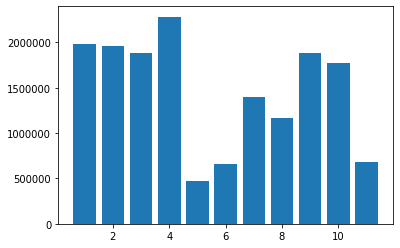

In [56]:
plt.bar(range(1, 12), mean_income)
plt.show()

In [57]:
# we can see that the best time to create a studio is first 4 month of the year

#### seasonality of business

In [58]:
mean_income

est_month
1     1.986350e+06
2     1.956925e+06
3     1.886725e+06
4     2.284286e+06
6     4.747250e+05
7     6.565517e+05
8     1.396467e+06
9     1.169800e+06
10    1.886167e+06
11    1.768760e+06
12    6.778500e+05
Name: income, dtype: float64

In [59]:
# seasonality sales

season = data[(data['open_date'] < '2018-01-01') & (data['date'] > '2018-01-01')]
season['income'] = season['price'] * season['duration']
season['year'] = [x.year for x in season['date']]
season['month'] = [x.month for x in season['date']]
incomes = season.groupby(['year', 'month']).agg(np.sum)['income']
incomes = incomes[incomes.index]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [60]:
incomes = incomes[: -3]

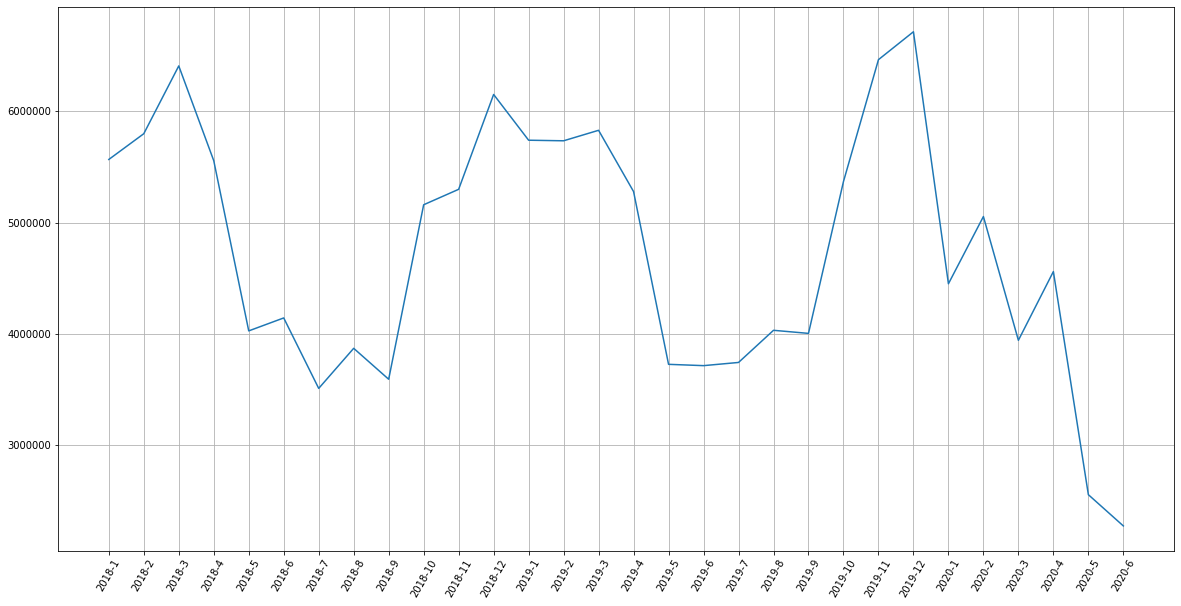

In [61]:
plt.figure(figsize = (20, 10))
plt.plot([str(x[0]) + '-' + str(x[1]) for x in incomes.index], incomes)
plt.xticks(rotation=60) 
plt.grid()
plt.show()

In [62]:
# we can see the pronounced seasonality of business
# low sales in may - september and high sales in october - april

#### income for hall

In [63]:
# hall income
hall_income = season.groupby(['studio_id','hall_id', 'year', 'month']).agg(sum)['income'].reset_index()
hall_income = hall_income[hall_income['year'] < 2020]
hall_income['income'].describe()

count       648.000000
mean     184299.691358
std      114304.925311
min           0.000000
25%       95575.000000
50%      170350.000000
75%      256575.000000
max      617400.000000
Name: income, dtype: float64

In [64]:
# the average income per hall is 170 000 - 180 000 rub./month
# half of studios earns from 95 000 to 255 000 rub./month

In [65]:
# income per hall in amount of halls in studio
(hall_income
 .groupby(['studio_id', 'hall_id']).agg('mean').reset_index()
 .groupby('studio_id').agg(['count', 'mean'])['income']
 .groupby('count').agg('mean')
)

,mean
count,
1,134847.916667
2,146531.944444
3,300231.944444
4,222202.604167


In [66]:
# studios with 3 halls have the highest income

In [67]:
#income and metro

data['income'] = data['price'] * data['duration']
data['year'] = [x.year for x in data['date']]
data['month'] = [x.month for x in data['date']]
(data
 .groupby(['hall_id', 'metro', 'year', 'month']).agg('sum')['income'].reset_index()
 .groupby(['hall_id', 'metro']).agg('mean')['income'].reset_index()
 .groupby('metro').agg('mean')['income'].sort_values()
)[-59:]

metro
электрозаводская                               5016.666667
метро Алексеевская                            10485.264378
Дубровка                                      11925.000000
Марксистская/Нижегородская                    18116.666667
Новогиреево,  Щелковская                      19000.000000
Войковская                                    21963.333333
Текстильщики                                  30667.051729
Нижегородская                                 31031.250000
Нагатинская                                   37787.500000
Павелецкая/Добрынинская                       39357.142857
Партизанская                                  44354.375000
Полежаевская                                  45888.888889
Волгоградский проспект                        46566.666667
Чкаловская                                    48541.666667
м. Марксистская, МЦК Нижегородская            49086.503623
Красносельская                                55340.659341
Речной вокзал,  Митино,  Комсомольская        5594

In [68]:
# we can mark this income per hall on the map and compare with rent for choosing best place to create studio

#### how many halls have studios?

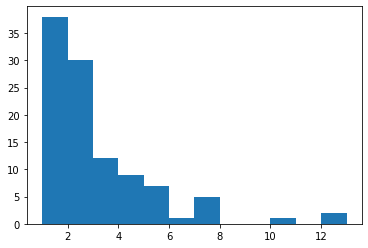

count    105.000000
mean       2.685714
std        2.292606
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       13.000000
Name: is_hall, dtype: float64

In [69]:
#amount of halls in one studio

hall_num = studios.merge(halls, left_on='studio_id', right_on='studio_id').groupby('studio_id').agg('count')['is_hall']

plt.hist(hall_num, range(np.min(hall_num), np.max(hall_num)+1))
plt.show()
hall_num.describe()

In [70]:
# studios have 1 - 4 halls.
# the average number of halls per studio is 2-3

#### how ceilings, floor space, and rental prices affect hall income

In [71]:
halls_sq_ceil = (data
 .groupby(['hall_id', 'ceiling', 'square', 'year', 'month']).agg('sum')['income'].reset_index()
 .groupby(['hall_id', 'ceiling', 'square']).agg('mean')['income'].reset_index()
)

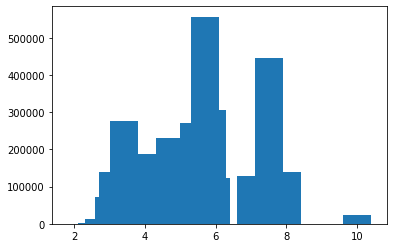

In [72]:
# ceiling
plt.bar(halls_sq_ceil.groupby('ceiling').agg('mean')['income'].index[:-2],
        halls_sq_ceil.groupby('ceiling').agg('mean')['income'][: len(halls_sq_ceil) - 2]
       )
plt.show()

In [73]:
# studios have halls with ceilings of 3-8 meters
# the best high is about 5 meters

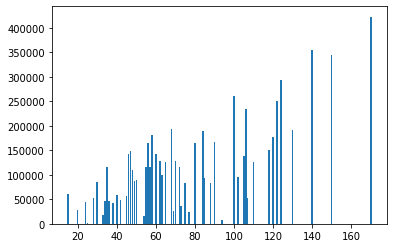

In [74]:
# square
square = halls_sq_ceil.groupby('square').agg('mean')['income']
plt.bar(square.index[:-3],
        square.iloc[: len(square) - 3]
       )
plt.show()

In [75]:
# Hall income is proportionally dependent on its area

In [76]:
price = (data
 .groupby(['hall_id', 'price', 'year', 'month']).agg('sum')['income'].reset_index()
 .groupby(['hall_id', 'price']).agg('mean')['income'].reset_index()
 .groupby('price').agg('mean')['income']
)

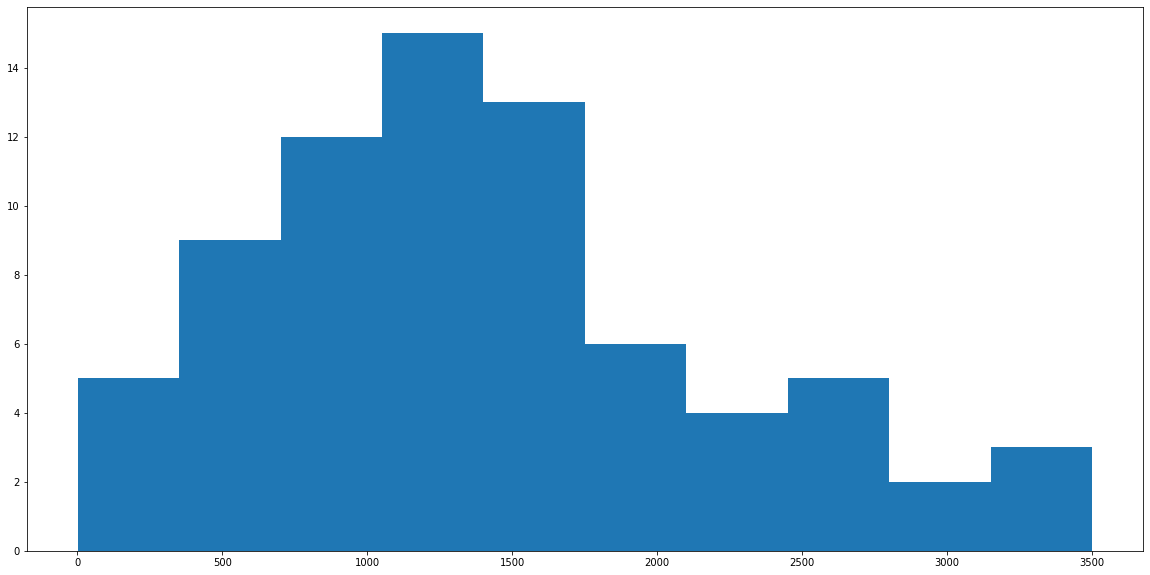

In [77]:
# hourly rate
plt.figure(figsize = (20, 10))
plt.hist(price.iloc[: len(price) - 5].index)
plt.show()

In [78]:
# most studios have an hourly rate of less than 2000 rub.
# the most popular rate is 800 - 900 rub.

In [79]:
price = price[price > 10000]

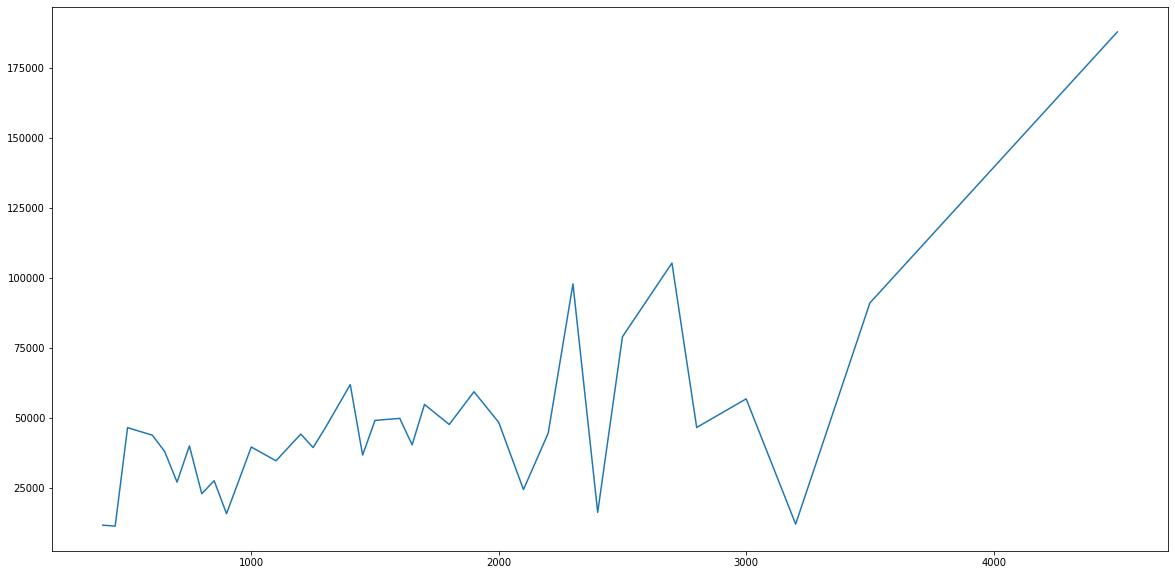

In [80]:
plt.figure(figsize = (20, 10))
plt.plot(price.index, price)
plt.show()

In [81]:
# the most prifitable studios have hourly rate of more than 2300
# but customers need to know what they pay for